In [1]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from torch import tensor
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
#from numba import jit
import pickle
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
from torch.cuda import FloatTensor
import torch
from torchsummary import summary
import seaborn as sns
import sys
import torch.nn.functional as F
# Req for package
sys.path.append("../")
from SkinLearning.Utils.Plotting import plotParameterBars
from SkinLearning.Utils.Dataset import getDataset, getSplit
from SkinLearning.Utils.NN import train, test, DEVICE

torch.backends.cudnn.benchmark = True

In [2]:
seed = 123
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Model

In [3]:
# Up samples to 256 from 128
class DualUp(nn.Module):
    def __init__(self):
        super(DualUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.conv4 = nn.Conv1d(512, 1024, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(1024)
        
        
        self.fc1 = nn.Linear(7680, 512)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 64)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        
        x = self.fc4(x)
        return x

In [4]:
# Up samples to 256 from 128
class Up(nn.Module):
    def __init__(self):
        super(Up, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.d2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        self.d3 = nn.Dropout(0.2)
        
        
        self.fc1 = nn.Linear(7680, 512)
        self.d5 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.d6 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 64)
        self.d7 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.d1(self.conv1(x)))))
        x = self.pool2(torch.relu(self.bn2(self.d2(self.conv2(x)))))
        x = self.pool3(torch.relu(self.d3(self.bn3(self.conv3(x)))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d5(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d6(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d7(x)
        
        
        x = self.fc4(x)
        return x

In [5]:
# Up samples to 256 from 128
class UpMinus(nn.Module):
    def __init__(self):
        super(UpMinus, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.d2 = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(7680, 512)
        self.d5 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.d6 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 64)
        self.d7 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.d1(self.conv1(x)))))
        x = self.pool2(torch.relu(self.bn2(self.d2(self.conv2(x)))))
        
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d5(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d6(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d7(x)
        
        
        x = self.fc4(x)
        return x

In [6]:
# Up samples to 256 from 128
class UpPlus(nn.Module):
    def __init__(self):
        super(UpPlus, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.d1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.d2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        self.d3 = nn.Dropout(0.2)
        
        self.conv4 = nn.Conv1d(512, 1024, kernel_size=3, padding=1, bias=False)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(1024)
        self.d4 = nn.Dropout(0.2)
        
        """self.conv4 = nn.Conv1d(512, 1500, kernel_size=3, padding=1, bias=False)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(1500)
        self.d5 = nn.Dropout(0.5)"""
        
        
        self.fc1 = nn.Linear(7168, 512)
        self.d6 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.d7 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 64)
        self.d8 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.d2(self.conv1(x)))))
        x = self.pool2(torch.relu(self.bn2(self.d3(self.conv2(x)))))
        x = self.pool3(torch.relu(self.bn3(self.d4(self.conv3(x)))))
        
        x = self.pool4(torch.relu(self.bn4(self.d4(self.conv4(x)))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d6(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d7(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d8(x)
        
        
        x = self.fc4(x)
        return x

In [7]:
# Up samples to 256 from 128
# Up samples to 256 from 128
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.conv4 = nn.Conv1d(512, 1024, kernel_size=3, padding=1, bias=False)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(1024)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        self.fc1 = nn.Linear(131072, 1024)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024 , 512)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, _ = self.rnn(x, h0)
        
        x = x.reshape(batch_size, -1)
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = self.d1(self.fc3(x))
        x = self.fc4(x)
        
        x = x.view(batch_size, 6)
        return x

# Training

In [8]:
dataset, scaler = getDataset()

100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:08<00:00, 256.18it/s]


In [9]:
train_loader, test_loader = getSplit(dataset)

In [10]:
up = Up()

In [11]:
up_losses, up_val_losses, = train(train_loader, up, val_loader=test_loader, LR=0.0001, epochs=300)

Using: cuda:0


Epoch 68/300: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 134.13batch/s, lastLoss=0.139, valLoss=0.195]


Epoch 136/300: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 121.60batch/s, lastLoss=0.125, valLoss=0.18]


Epoch 204/300: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 129.48batch/s, lastLoss=0.12, valLoss=0.165]


Epoch 272/300: 100%|████████████████████████████████| 56/56 [00:00<00:00, 126.27batch/s, lastLoss=0.116, valLoss=0.152]


Epoch 300/300: 100%|████████████████████████████████| 56/56 [00:00<00:00, 125.42batch/s, lastLoss=0.116, valLoss=0.146]


Average train loss: 0.13173914146653953
Average validation loss: 0.17582866737494865


In [12]:
upMinus = UpMinus()

In [13]:
up2_losses, up2_val_losses, = train(train_loader, upMinus, val_loader=test_loader, LR=0.0001, epochs=300)

Using: cuda:0


Epoch 68/300: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 146.40batch/s, lastLoss=0.139, valLoss=0.149]


Epoch 136/300: 100%|████████████████████████████████| 56/56 [00:00<00:00, 139.82batch/s, lastLoss=0.125, valLoss=0.136]


Epoch 204/300: 100%|████████████████████████████████| 56/56 [00:00<00:00, 152.38batch/s, lastLoss=0.121, valLoss=0.129]


Epoch 272/300: 100%|████████████████████████████████| 56/56 [00:00<00:00, 144.70batch/s, lastLoss=0.117, valLoss=0.125]


Epoch 300/300: 100%|████████████████████████████████| 56/56 [00:00<00:00, 151.76batch/s, lastLoss=0.115, valLoss=0.118]


Average train loss: 0.1317817791019167
Average validation loss: 0.14534774981025192


In [14]:
upPlus = UpPlus()

In [15]:
upPlus_losses, upPlus_val_losses, = train(train_loader, upPlus, val_loader=test_loader, LR=0.0001, epochs=300)

Using: cuda:0


Epoch 68/300: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 101.27batch/s, lastLoss=0.137, valLoss=0.204]


Epoch 136/300: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 107.28batch/s, lastLoss=0.127, valLoss=0.18]


Epoch 204/300: 100%|████████████████████████████████| 56/56 [00:00<00:00, 104.93batch/s, lastLoss=0.119, valLoss=0.171]


Epoch 272/300: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 112.57batch/s, lastLoss=0.116, valLoss=0.15]


Epoch 300/300: 100%|████████████████████████████████| 56/56 [00:00<00:00, 111.00batch/s, lastLoss=0.115, valLoss=0.156]


Average train loss: 0.13066870602557348
Average validation loss: 0.17879273004829885


In [16]:
rnn = RNN()

In [17]:
rnn_losses, rnn_val_losses, = train(train_loader, rnn, val_loader=test_loader, LR=0.0001, epochs=300)

Using: cuda:0


Epoch 68/300: 100%|█████████████████████████████████| 56/56 [00:03<00:00, 18.66batch/s, lastLoss=0.108, valLoss=0.0917]


Epoch 136/300: 100%|███████████████████████████████| 56/56 [00:02<00:00, 21.30batch/s, lastLoss=0.0928, valLoss=0.0712]


Epoch 204/300: 100%|███████████████████████████████| 56/56 [00:02<00:00, 20.65batch/s, lastLoss=0.0834, valLoss=0.0694]


Epoch 272/300: 100%|███████████████████████████████| 56/56 [00:02<00:00, 20.68batch/s, lastLoss=0.0803, valLoss=0.0587]


Epoch 300/300: 100%|████████████████████████████████| 56/56 [00:02<00:00, 20.73batch/s, lastLoss=0.077, valLoss=0.0607]


Average train loss: 0.0969773908906306
Average validation loss: 0.0782629882827815


In [18]:
upDef = DualUp()

In [19]:
upDef_losses, upDef_val_losses, = train(train_loader, upDef, val_loader=test_loader, LR=0.0001, epochs=400)

Using: cuda:0


Epoch 68/400: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 127.88batch/s, lastLoss=0.132, valLoss=0.134]


Epoch 136/400: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 120.30batch/s, lastLoss=0.12, valLoss=0.107]


Epoch 204/400: 100%|███████████████████████████████| 56/56 [00:00<00:00, 118.89batch/s, lastLoss=0.111, valLoss=0.0967]


Epoch 272/400: 100%|███████████████████████████████| 56/56 [00:00<00:00, 121.35batch/s, lastLoss=0.105, valLoss=0.0977]


Epoch 340/400: 100%|███████████████████████████████| 56/56 [00:00<00:00, 113.25batch/s, lastLoss=0.101, valLoss=0.0939]


Epoch 400/400: 100%|███████████████████████████████| 56/56 [00:00<00:00, 129.31batch/s, lastLoss=0.0961, valLoss=0.103]


Average train loss: 0.11832571898354217
Average validation loss: 0.1116392238540575


In [22]:
sns.set_theme()

"""
    Plots train and test curves of given models
"""
def printCurves(names, train_loss, val_loss, epochs=300, name="train_test2"):
    if len(names)%2 == 0:
        rs = len(names)//2
        cs = len(names)//2
    else:
        rs, cs = len(names), 1
        
    fig, ax = plt.subplots(
        rs, cs, figsize=(35 if len(names) != 1 else 10, len(names)*6), sharex=True, sharey=True, constrained_layout=True)
    x = range(0, epochs)
    fig.supxlabel("Epoch", fontsize=45)
    fig.supylabel("MAE", fontsize=45)

    #ax[0][1].set_xlabel("Training Loss")
    ##ax[1][1].set_xlabel("Validation Loss")
    
    tv_loss = list(zip(train_loss, val_loss))
    if cs == 1 and rs == 1:
        ax.set_title(names[0], fontsize=40)
        ax.xaxis.set_tick_params(labelsize=35)
        ax.yaxis.set_tick_params(labelsize=35)
        for j in range(2):
            ax.plot(x, tv_loss[0][j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")
    elif cs == 1:
        for i in range(len(names)):
            ax[i].set_title(names[i], fontsize=40)
            ax[i].xaxis.set_tick_params(labelsize=35)
            ax[i].yaxis.set_tick_params(labelsize=35)
            for j in range(2):
                ax[i].plot(x, tv_loss[i][j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")
    else:
        pos = 0
        for i in range(rs):
            for j in range(cs):
                ax[i][j].set_title(names[pos], fontsize=40)
                ax[i][j].xaxis.set_tick_params(labelsize=35)
                ax[i][j].yaxis.set_tick_params(labelsize=35)
                for k in range(2):
                    ax[i][j].plot(x, tv_loss[pos][k], c = "b" if k == 0 else "y", label = "Train loss" if k == 0 else "Validation loss")
    
                pos += 1
        
    #plt.xticks(fontsize=14, rotation=90)
    plt.legend(loc='best', prop={'size':30})
    plt.show()
    fig.savefig(f"../Results/{name}.svg", bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (300,) and (400,)

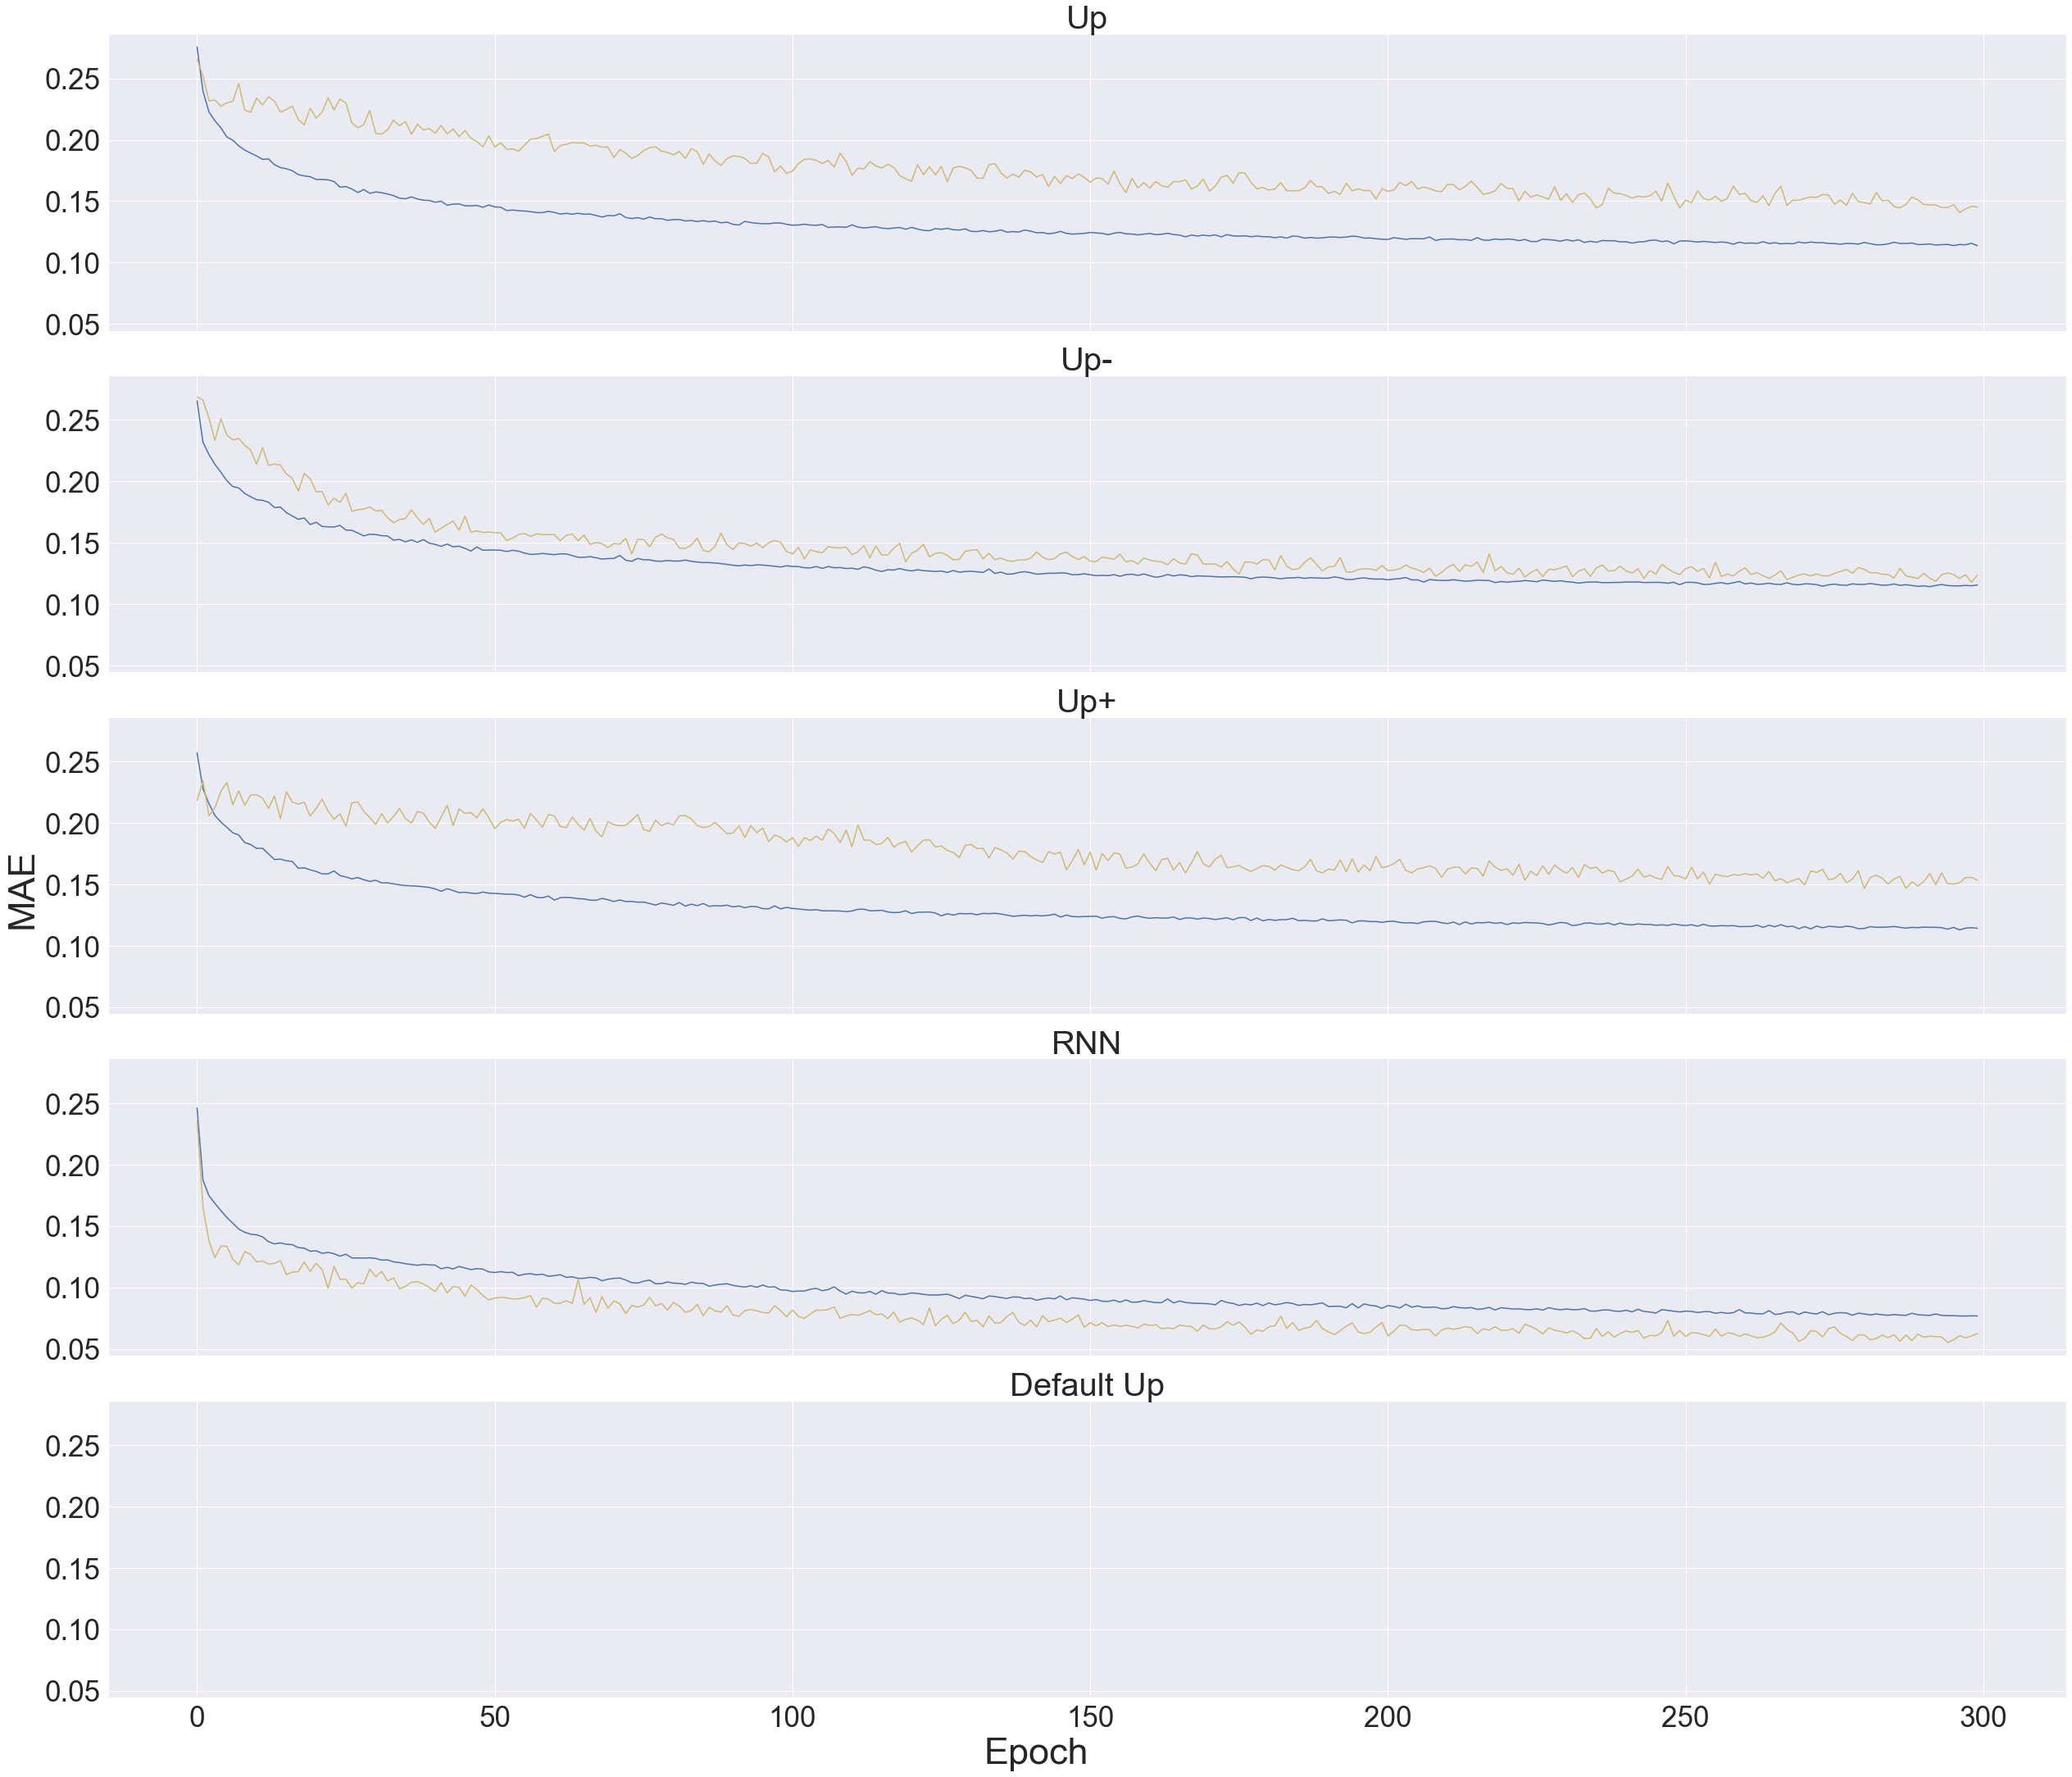

In [23]:
printCurves(
    ["Up", "Up-", "Up+", "RNN", "Default Up"],
    [up_losses, up2_losses, upPlus_losses, rnn_losses, upDef_losses],
    [up_val_losses, up2_val_losses, upPlus_val_losses, rnn_val_losses, upDef_val_losses])

## The addition of an RNN dramatically improves performance

In [ ]:
printCurves(["RNN"], [rnn_losses], [rnn_val_losses])

In [47]:
"""
    Run evaluation and build a dataframe of parameter accuracies
    Accuracies are calculated as 100-MAPE
"""
def getParameterLoss(models, names, test_loader=test_loader):
    params = []
    overall = []
    
    # Run evaluation on all models
    for model in models:
        avg, ps, _ = test(test_loader, model, scaler=scaler)
        overall.append(avg)
        params.append(ps)
    
    all_vals = np.array(params)
    df = pd.DataFrame({
        "Architecture": names,
        "YM (Skin)": all_vals[:, 0],
        "YM (Adipose)": all_vals[:, 1],
        "PR (Skin)": all_vals[:, 2],
        "PR (Adipose)": all_vals[:, 3],
        "Perm (Skin)": all_vals[:, 4],
        "Perm (Adipose)": all_vals[:, 5],
        "Overall": overall
    })
    
    df = df.set_index("Architecture")
    df_p = df.style.set_caption(
        'Average percent correctness 100-MAPE').set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'black'),
            ('font-size', '16px'),
            ('text-align', 'center')
        ]
    }])
    display(df_p)
    
    return df
    
"""printVals = lambda x: print(''.join(
    'YM 1: {:.2f}%, YM 2: {:.2f}%, PR 1: {:.2f}%,  PR 2: {:.2f}%, Perm 1: {:.2f}%, Perm 2: {:.2f}%'.format(*x)))    """

"printVals = lambda x: print(''.join(\n    'YM 1: {:.2f}%, YM 2: {:.2f}%, PR 1: {:.2f}%,  PR 2: {:.2f}%, Perm 1: {:.2f}%, Perm 2: {:.2f}%'.format(*x)))    "

In [48]:
"""
    Validates the given model on the given validation loader
    Returns 100-MAPE for each batch and each parameter
"""
def test(test_loader, net, scaler):
    net.to(DEVICE)
    net.eval()
    criterion = nn.L1Loss()

    losses = []
    p_losses = []
    mae = []

    with torch.no_grad():
        with tqdm(test_loader, unit=" batch") as it:
            for idx, data in enumerate(it):
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                predicted = net(inp)
                
                # Denormalise
                p = scaler.inverse_transform(predicted.cpu().numpy())
                o = scaler.inverse_transform(out.cpu().numpy())
                    
                # Get column wise and overall MAPE
                # Since each column is normalised should also be able to use MAE*100
                p_loss = np.mean(100*(np.abs(o-p)/o), axis=0)
                loss = np.mean(100*(np.abs(o-p)/o))

                mae.append(criterion(predicted, out).item())
        
            
                p_losses.append(p_loss)
                losses.append(loss)

            
    average_mape = 100 - np.mean(losses)
    average_p_loss = 100 - np.mean(p_losses, axis=0)
    mae_mean = np.mean(mae)
    
    return average_mape, average_p_loss, mae_mean

In [49]:
test(train_loader, rnn, scaler)

100%|█████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 115.23 batch/s]


(89.3141736984253,
 array([94.87419 , 84.59088 , 99.73239 , 99.75828 , 71.22202 , 85.707275],
       dtype=float32),
 0.05525055534339377)

In [50]:
df = getParameterLoss([up, upMinus, upPlus, rnn, upDef],["Up", "Up-", "Up+", "RNN", "Default Up"])

100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.37 batch/s]


,YM (Skin),YM (Adipose),PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall
Architecture,,,,,,,
Up,91.683434,55.226231,99.718666,99.158783,38.148899,52.077011,72.668837
Up-,93.318832,47.317848,99.715309,99.273285,39.333347,65.260811,74.036573
Up+,91.740517,54.075012,99.709930,99.186249,33.977379,53.129700,71.969793
RNN,94.608025,82.992149,99.736168,99.723831,69.475189,87.575081,89.018407
Default Up,94.035782,61.367847,99.710197,99.571854,44.548843,78.206650,79.573530


(60.0, 100.0)

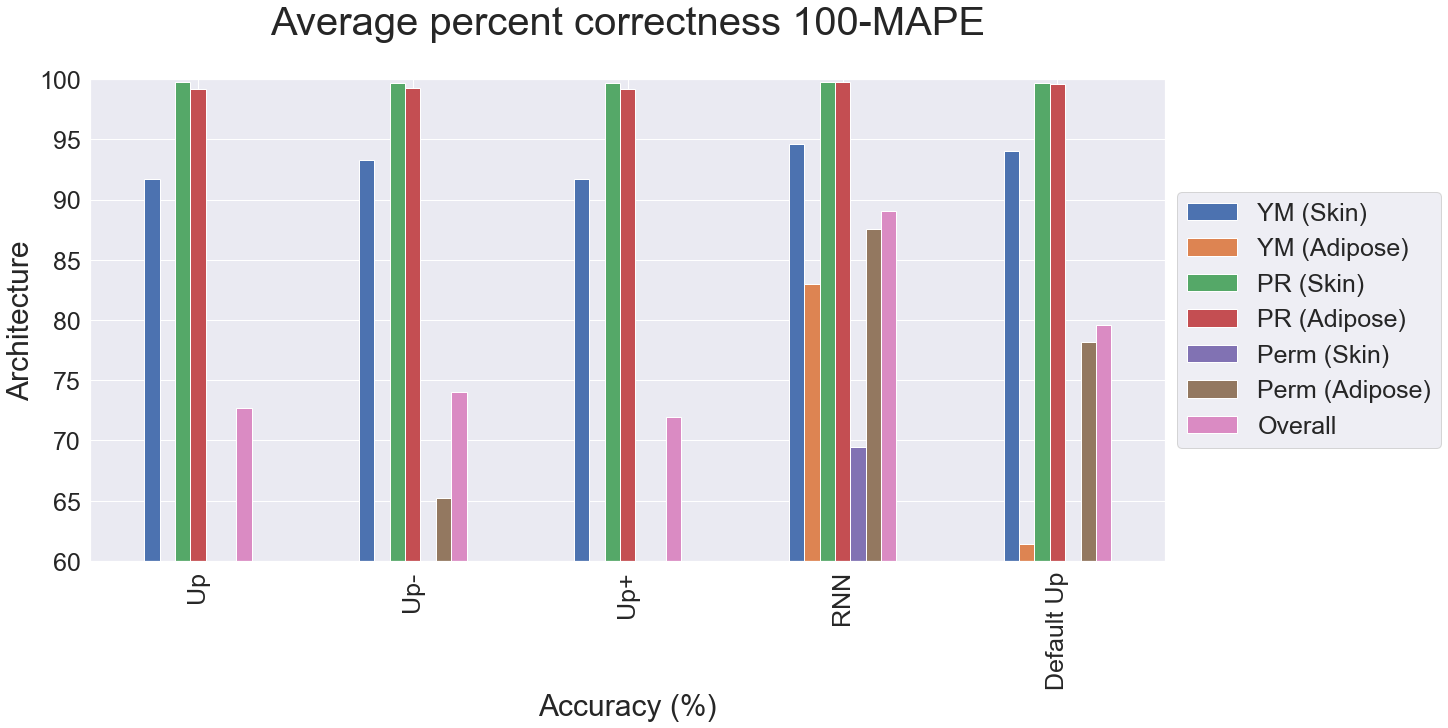

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
df.plot.bar(ax=ax)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_ylabel("Architecture", fontsize=30)
ax.set_xlabel("Accuracy (%)", fontsize=30)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  prop={'size': 25})
ax.set_title("Average percent correctness 100-MAPE", size=40, y=1.08)
ax.set_ylim(60, 100)
#fig.savefig("../Results/testArchitecturesbarmspe.svg", bbox_inches='tight')

(60.0, 100.0)

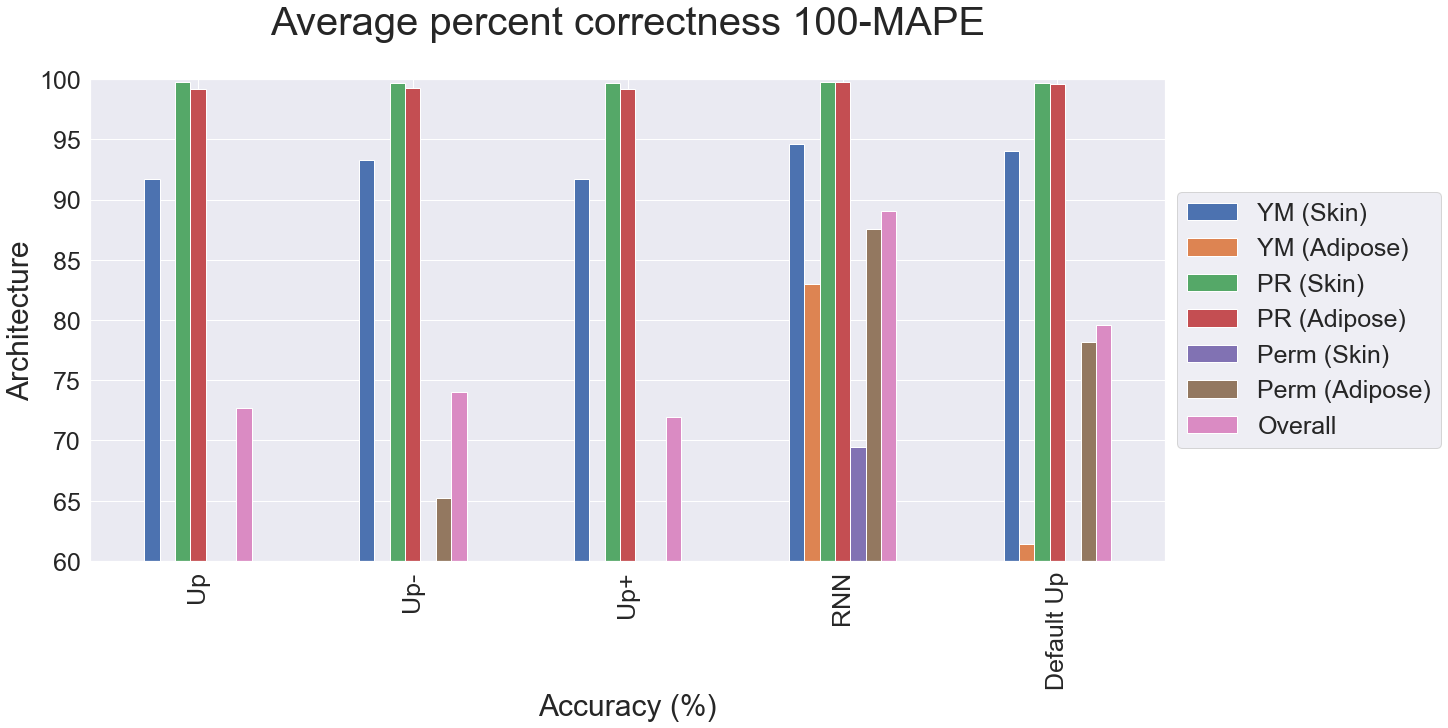

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
df.plot.bar(ax=ax)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_ylabel("Architecture", fontsize=30)
ax.set_xlabel("Accuracy (%)", fontsize=30)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  prop={'size': 25})
ax.set_title("Average percent correctness 100-MAPE", size=40, y=1.08)
ax.set_ylim(60, 100)
#fig.savefig("../Results/testArchitecturesbarmspe.svg", bbox_inches='tight')